# Machine Learning: Decision Tree

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from IPython.display import display, Latex, Markdown
import matplotlib.pyplot as plt

In [2]:
#importing state population counts from 2010 - 2019
state_populations = pd.read_excel('us_states_census.xlsx')

#cleaning state population data
state_populations.columns = ['state', 'census', 'estimates base', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']#state_populations.iloc[2]
state_populations = state_populations.drop(columns = ['census', 'estimates base'])
state_populations = state_populations[8:59]
state_populations = state_populations.reset_index(drop=True)
state_populations.state = [state.replace('.', '') for state in list(state_populations.state)]

state_populations.head(5)

,state,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Alabama,4785437,4799069.0,4815588.0,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0,4903185.0
1,Alaska,713910,722128.0,730443.0,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0,731545.0
2,Arizona,6407172,6472643.0,6554978.0,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0,7278717.0
3,Arkansas,2921964,2940667.0,2952164.0,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0,3017804.0
4,California,37319502,37638369.0,37948800.0,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0,39512223.0


In [3]:
# gun violence cases dataset cleaned
cases = pd.read_csv('stage3.csv')
cases = cases.loc[:, ['date', 'state', 'n_killed', 'n_injured']]

cases['date'] = pd.to_datetime(cases['date'])
cases['year'] = cases['date'].dt.year
cases['harmed'] = cases['n_killed'] + cases['n_injured']
cases = cases.drop(columns=['date', 'n_killed', 'n_injured'])
cases = cases[(cases['year'] > 2013) & (cases['year'] < 2018)]
cases = cases.groupby(['state', 'year']).agg('sum')
cases = cases.reset_index()

#adding population counts to cases dataset by matching year and state
for i, row in cases.iterrows():
    cases.at[i, ('population')] = float(state_populations[state_populations.state == row['state']][str(row['year'])])

#compute the proportion of harmed individuals due to a gun incident out of the state population 
cases['proportion_harmed'] = cases['harmed']/cases['population']
cases.drop(columns=['harmed', 'population'], inplace=True)
cases.head(5)

,state,year,proportion_harmed
0,Alabama,2014,0.000189
1,Alabama,2015,0.000195
2,Alabama,2016,0.000257
3,Alabama,2017,0.000287
4,Alaska,2014,0.000106


In [4]:
# Check if gun cases were reduced based on previous year values (only valid for 2015-2017)
harmed = cases['proportion_harmed'].tolist()
decrease = list()

# False = Increase (Decrease = 0), True = Decrease (Decrease = 1)
for i in range(0, len(harmed), 4):
    decrease.append(False)                           # Year 2014; Temporary Place-Holder
    decrease.append(harmed[i] > harmed[i+1])         # Year 2015
    decrease.append(harmed[i+1] > harmed[i+2])       # Year 2016
    decrease.append(harmed[i+2] > harmed[i+3])       # Year 2017

cases['decrease_in_gun_violence'] = pd.Series(decrease)
cases = cases.drop(labels=range(0, len(decrease), 4), axis=0)
cases = cases[(cases['state'] != 'District of Columbia')]
cases.head(5)

,state,year,proportion_harmed,decrease_in_gun_violence
1,Alabama,2015,0.000195,False
2,Alabama,2016,0.000257,False
3,Alabama,2017,0.000287,False
5,Alaska,2015,0.000209,False
6,Alaska,2016,0.000258,False


`MR: Instead of using the raw count to compare, we should factor in state population on a yearly basis and compare the proportion of cases 
alongside the population increase/decrease (ex. #cases in Alabama 2015/ population count Alabama 2015)`


In [5]:
#  gun laws dataset cleaned
laws = pd.read_csv('statefirearmlaws.csv')
laws = laws[(laws['year'] > 2014) & (laws['year'] < 2018)]
laws.head(5)

,state,year,felony,invcommitment,invoutpatient,danger,drugmisdemeanor,alctreatment,alcoholism,relinquishment,...,expartedating,dvrosurrender,dvrosurrendernoconditions,dvrosurrenderdating,expartesurrender,expartesurrendernoconditions,expartesurrenderdating,dvroremoval,stalking,lawtotal
24,Alabama,2015,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,10
25,Alabama,2016,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,10
26,Alabama,2017,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,10
54,Alaska,2015,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
55,Alaska,2016,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [6]:
# Combined dataset
data = cases.merge(laws, on=['state', 'year'], how='outer')
# data = data.drop(columns=['year', 'harmed', 'lawtotal']) #i think we should keep all these columns
data.head(5)

,state,year,proportion_harmed,decrease_in_gun_violence,felony,invcommitment,invoutpatient,danger,drugmisdemeanor,alctreatment,...,expartedating,dvrosurrender,dvrosurrendernoconditions,dvrosurrenderdating,expartesurrender,expartesurrendernoconditions,expartesurrenderdating,dvroremoval,stalking,lawtotal
0,Alabama,2015,0.000195,False,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,10
1,Alabama,2016,0.000257,False,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,10
2,Alabama,2017,0.000287,False,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,10
3,Alaska,2015,0.000209,False,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,Alaska,2016,0.000258,False,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


Create the features and labels for classification.

In [7]:
def create_features_labels(dataset): 
    X = dataset.drop(columns = ['decrease_in_gun_violence', 'state', 'year']) #keep all law reform info as features, as well as the proportion of individuals harmed
    y = dataset['decrease_in_gun_violence']   # Labels are if the number of cases reduced
    y = y.replace({True: 1, False: 0})
    return X, y

X, y = create_features_labels(data)

In [32]:
#checking proportion of classes w.r.t 'decrease'
print(f'Number of examples in our entire dataset where decrease_in_gun_violence=0: {len(y[y == 0])}')
print(f'Number of examples in our entire dataset where decrease_in_gun_violence=1: {len(y[y == 1])}')

Number of examples in our entire dataset where decrease_in_gun_violence=0: 101
Number of examples in our entire dataset where decrease_in_gun_violence=1: 49


Create a baseline classifier `MajorityLabelClassifier` to test our classifier against. This will always predict the class equal to the mode of the labels.

In [10]:
class MajorityLabelClassifier():
    # Initialize parameter for the classifier
    def __init__(self):
        self.mode = 0
    
    # Fit the data by taking training data X and their labels y and storing the learned parameter
    def fit(self, X, y):
        modes = dict()           # Stores all the modes of the training data
        y = y.tolist()
        for i in range(len(X)):
            if y[i] in modes.keys():
                modes[y[i]] += 1
            else:
                modes[y[i]] = 1
                
        # Find the most frequent mode and store it
        total = 0
        for key in modes:
            if modes[key] > total:
                total = modes[key]
                self.mode = key
    
    # Predict the label for each instance X as the learned parameter
    def predict(self, X):
        labels = list()
        for i in X:
            labels.append(self.mode)
        return labels
    
    # Calculate the accuracy of our classifier using the true and predicted labels
    def evaluate_accuracy(self, y, y_predict):
        accurate_pred = 0
        total = len(y_predict)
        true_labels = y.tolist()
        
        for i in range(total):
            if true_labels[i] == y_predict[i]:
                accurate_pred += 1
        return accurate_pred/total

In [11]:
baseline = MajorityLabelClassifier()
baseline.fit(X, y)
labels = baseline.predict(X)
print(baseline.evaluate_accuracy(y, labels))

0.6838235294117647


Evaluate the `DecisionTreeClassifier()` by training, fitting, and predicting on the data.

`we should use cross validation to fine tune some of our parameters and try to increase our accuracy up to 80%`

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=1) #changed split to 80% train, 20% test
clf_model = DecisionTreeClassifier()   
clf_model.fit(X_train,y_train)
y_predict = clf_model.predict(X_test)

Train Accuracy: 0.8866666666666667
Test Accuracy: 0.43333333333333335
precision: [0.73333333 0.13333333]
recall   : [0.45833333 0.33333333]
f1 score : [0.56410256 0.19047619]


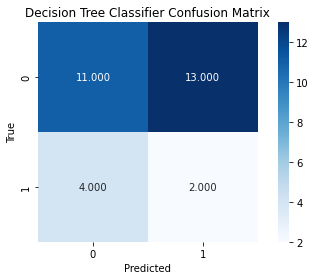

In [23]:
#evaluation metrics
train_accuracy = clf_model.score(X,y)  #this gives training accuracy
test_accuracy = accuracy_score(y_test, y_predict) #this gives testing accuracy

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

cm = confusion_matrix(y_test, y_predict) #confusion matrix
precision, recall, f1, support =  precision_recall_fscore_support(y_test, y_predict) #precision, recall, f1 score, and support for each class (decrease_in_gun_violence=0 and decrease_in_gun_violence=1)

print(f'precision: {precision}')
print(f'recall   : {recall}')
print(f'f1 score : {f1}')

#plot confusion matrix
sns.heatmap(cm, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues);
plt.ylabel('True');
plt.xlabel('Predicted');
plt.title('Decision Tree Classifier Confusion Matrix');
plt.tight_layout();

`our train accuracy is much higher than our test accuracy --> we may be overfitting: consider (post) pruning the tree`

Our classifier also seems to be performing better for one class (decrease=0) than the other class (decrease=1). This may be due to an imbalance in class labels in our dataset (more decrease=0 than decrease=1).
In our dataset, we have 101 entries where decrease = 0 and only 49 entries where decrease=1.

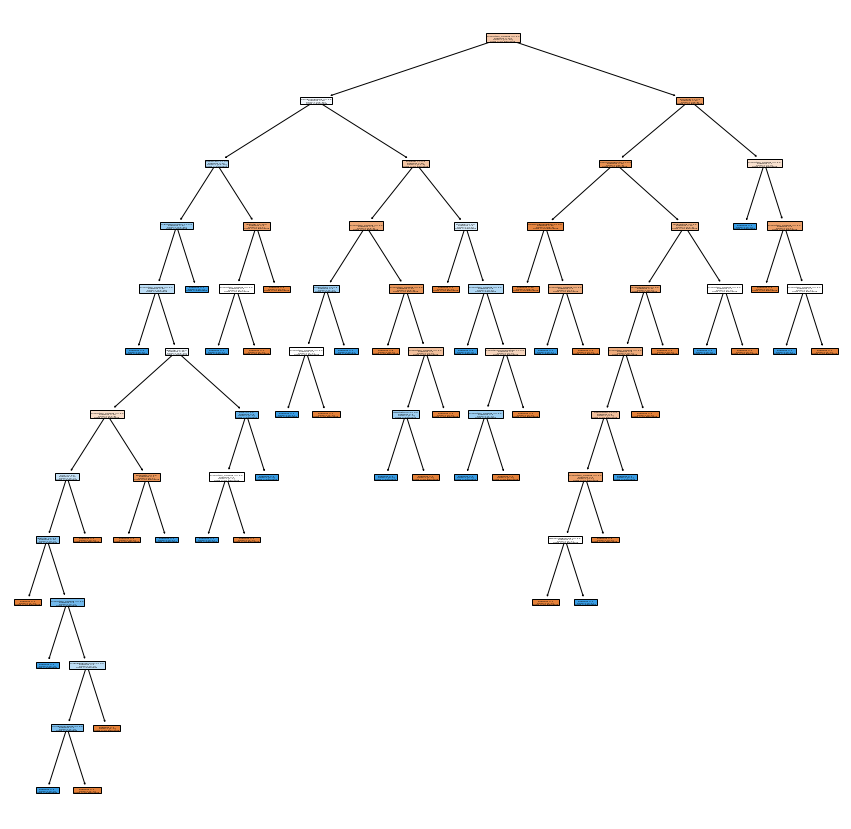

In [13]:
#visualizing decision tree classifier
feature_names_list = list(X.columns) 
plt.figure(figsize=(15,15))
plot_tree(clf_model, feature_names = feature_names_list,  
          class_names = ['No Decrease', 'Decrease'], 
          filled = True, impurity = False); #class names match to `decrease` values [0=did not decrease, 1=did decrease]

To Do (04/02/2022):
- `add state population counts and use proportions instead of raw counts to compare decrease in gun violence`
- `change target label to 'decrease_in_gun_violence'`
- put MajorityLabelClassifier class in a .py file of its own and just import to avoid going over 5 page limit
- fine tune parameters on DT using cross validation (ex. depth of decision tree)
- `visualize decisision tree with sklearn function`
- add additional features about participant info such as mean participant age, mean victim age, mean suspect age on a per state/year basis
- `view results using additional metrics namely: accuracy, confusion matrix, f1 score, precision, and recall`

(items in `yellow` have been completed + implemented)

Notes on Performance of Decision Tree (April 03 2022):
- classes are heavily imbalanced (101 rows where there was no decrease in gun violence and 49 rows where there was a decrease in gun violence)
- decision tree is overfitting on our train data: 88% train accuracy, 43% test accuracy

Next steps:
- try using cross validation to fit our tree
- we can try pruning the tree to try and avoid overfitting
- currently unsure how to handle class imbalances in data